# Crop Yield Prediction - Deep Learning

We pass seasonal time series of crop model outputs, weather and FAPAR to 1DCNN or LSTM layers to extract features from them. Learned seasonal features, yield trend features (yield values of 5 previous years) and static features are passed to the output layer.

In [ ]:
test_env = 'guanabana'

from d2l import torch as d2l
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession.builder.master("local[25]")\
                            .config("spark.driver.memory", "40g")\
                            .config("spark.driver.maxResultSize", "6g")\
                            .config("spark.executor.memory", "12g")\
                            .config("spark.network.timeout", "800s")\
                            .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, spatial_level=None, architecture=None):
  """Get filename based on input arguments"""
  filename = crop.replace(' ', '_')

  if (country is not None):
    filename += '_' + country

  if (spatial_level is not None):
    filename += '_' + spatial_level

  if (yield_trend):
    filename += '_trend'
  else:
    filename += '_notrend'

  if (early_season_end < 0):
    filename += '_early' + str(early_season_end)

  if (architecture is not None):
    filename += '-' + architecture

  return filename

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None, spatial_level=None, architecture=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end,
                         country=country,
                         spatial_level=spatial_level,
                         architecture=architecture)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, spatial_level=None, architecture=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end,
                       country=country,
                       spatial_level=spatial_level,
                       architecture=architecture)
  pred_file += suffix
  return pred_file

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val

  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, id_cols,
                                  order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select(id_cols).distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(id_cols + ['FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, id_col, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = [id_col, 'FYEAR', 'YIELD']
  my_window = Window.partitionBy(id_col).orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = [id_col, 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDS(src_df, sel_col, num_id_col):
  """Assigns monotonically increasing unique ids to selected col values"""
  id_df = src_df.select(sel_col).distinct().orderBy(sel_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float64')
  y_pred = y_pred.astype('float64')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def preprocessCSSF(self, cssf_df):
    cssf_df = cssf_df.withColumnRenamed('year', 'FYEAR')
    cssf_df = cssf_df.withColumnRenamed('dekad', 'DEKAD')
    cssf_df = cssf_df.drop(*['LONTD', 'LATTD'])

    return cssf_df

  def preprocessMeteo(self, meteo_df):
    """
    Calculate CWB.
    """
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))

    meteo_df = meteo_df.withColumnRenamed('year', 'FYEAR')
    meteo_df = meteo_df.withColumnRenamed('dekad', 'DEKAD')
    meteo_df = meteo_df.drop(*['LONTD', 'LATTD'])

    return meteo_df

  def preprocessRemoteSensing(self, rs_df):
    rs_df = rs_df.withColumnRenamed('year', 'FYEAR')
    rs_df = rs_df.withColumnRenamed('dekad', 'DEKAD')
    rs_df = rs_df.drop(*['LONTD', 'LATTD'])

    return rs_df

  def preprocessSoil(self, soil_df, id_cols):
    # SM_WHC = water holding capacity
    soil_df = soil_df.select(id_cols + ['SM_WHC'])

    return soil_df

  def preprocessCropArea(self, area_df):
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    # convert crop area into ha
    area_df = area_df.withColumn('CROP_AREA', SparkF.round(area_df['CROP_AREA'] * 0.404686, 3))

    return area_df

  def preprocessYield(self, yield_df, spatial_level='GRIDS'):
    """
    Convert county yields to t/ha.
    See https://www.ndwheat.com/buyers/chartsandstats/
    """
    if (spatial_level == 'COUNTY'):
      yield_df = yield_df.withColumn('YIELD', SparkF.round(yield_df['YIELD'] * 0.06725, 3))

    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)
    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date
from pyspark.sql import Window

from datetime import date

def loadDataFromCSVFile(spark, data_path, src, spatial_level, country_code):
    """
    The implied filename for each source is:
    <data_source>_<spatial_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '_' + country_code + '.csv'
    elif (spatial_level is not None):
      datafile = data_path + '/' + src  + '_' + spatial_level + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    spatial_level = data_sources[src]['spatial_level']
    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, spatial_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources,
                   crop, season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None

  # county_grids_df = data_dfs['COUNTY']
  # w = Window.partitionBy('GRID_ID')
  # county_grids_df = county_grids_df.withColumn('maxSHAPE_AREA', SparkF.max('TOTAL_AREA').over(w))
  # county_grids_df = county_grids_df.filter(county_grids_df['TOTAL_AREA'] == county_grids_df['maxSHAPE_AREA'])
  # county_grids_df = county_grids_df.drop(*['maxSHAPE_AREA', 'TOTAL_AREA'])
  # # ['AR', 'MO', 'TN', 'KY', 'IL', 'IN', 'KS', 'OH', 'NE', 'IA', 'PA', 'MI', 'WI', 'SD', 'MN', 'ND']
  # county_grids_df = county_grids_df.filter(SparkF.substring(county_grids_df['COUNTY_ID'], 1, 2) == 'IA')

  for src in data_sources:
    src_df = data_dfs[src] #.join(county_grids_df, ['GRID_ID']).drop('COUNTY_ID')
    sel_cols = data_sources[src]['sel_cols']
    spatial_level = data_sources[src]['spatial_level']

    # crop productivity data (CSSF)
    if (src == 'CSSF'):
      cssf_df = cyp_preprocessor.preprocessCSSF(src_df)
      assert (cssf_df is not None)
      data_dfs[src] = cssf_df.select(sel_cols)

    # meteo data
    if ('METEO' in src):
      meteo_df = cyp_preprocessor.preprocessMeteo(src_df)

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df.select(sel_cols)

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = cyp_preprocessor.preprocessRemoteSensing(src_df)
      assert (rs_df is not None)
      data_dfs[src] = rs_df.select(sel_cols)

    # soil data
    if (src == 'SOIL'):
      data_dfs['SOIL'] = src_df.select(sel_cols)

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = cyp_preprocessor.preprocessCropArea(src_df)
      data_dfs['CROP_AREA'] = crop_area_df.select(sel_cols)

    # label data
    if (src == 'YIELD'):
      yield_df = cyp_preprocessor.preprocessYield(src_df, spatial_level=spatial_level)
      data_dfs['YIELD'] = yield_df.select(sel_cols)

  # Print debug information
  for src in data_dfs:
    src_df = data_dfs[src]
    order_cols = data_sources[src]['order_cols']
    if ('GRID_ID' in src_df.columns):
      printPreprocessingInformation(src_df, src, ['GRID_ID'], order_cols)
    elif (print_debug):
      printPreprocessingInformation(src_df, src, ['COUNTY_ID'], order_cols)

  return data_dfs

def getLinearYieldTrend(pd_yield_ft_df, id_cols, trend_window):
  """Fits a linear trend model to yields from 5 previous years"""
  join_cols = id_cols + ['FYEAR']
  region_years = pd_yield_ft_df[join_cols].values
  prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  prev_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1)]
  window_years = pd_yield_ft_df[prev_year_cols].values
  window_yields = pd_yield_ft_df[prev_yield_cols].values

  yield_trend = []
  for i in range(region_years.shape[0]):
    coefs = np.polyfit(window_years[i, :], window_yields[i, :], 1)
    yield_trend.append(float(np.round(coefs[0] * region_years[i, 1] + coefs[1], 2)))

  pd_yield_ft_df['YIELD_TREND'] = yield_trend
  drop_cols = ['YEAR-' + str(i) for i in range(1, 6)]
  pd_yield_ft_df = pd_yield_ft_df.drop(columns=drop_cols)

  return pd_yield_ft_df

def combineInputData(data_sources, data_dfs,
                     ts_data_sources,
                     static_data_sources,
                     id_col,
                     trend_window=5,
                     early_season_end=None,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('FYEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('FYEAR')).collect()[0][0]
    # max of min years (earliest year after join, not min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, not max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['FYEAR'] >= input_min_year) &
                               (input_df['FYEAR'] <= input_max_year))
    if (dekadal_df is None):
      dekadal_df = input_df
    else:
      dekadal_df = dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      dekadal_df = dekadal_df.na.fill(0.0)

  max_dekad = 36
  if (early_season_end is not None):
    # early_season_end is relative to harvest (so 0 or negative)
    max_dekad += early_season_end
    dekadal_df = dekadal_df.filter(dekadal_df['DEKAD'] <= max_dekad)

  static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (static_df is None):
      static_df = input_df
    else:
      static_df = static_df.join(input_df, [id_col])

  label_df = data_dfs['YIELD']
  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, id_col, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Training, test splits are decided based on label years.
  country_years = sorted([yr[0] for yr in label_df.select('FYEAR').distinct().collect()])

  # Align spatial units and years
  static_df = static_df.na.drop()
  label_df = label_df.join(static_df.select(id_col).distinct(), [id_col])
  label_df = label_df.join(trend_ft_df.select([id_col, 'FYEAR']).distinct(), [id_col, 'FYEAR'])
  label_df = label_df.join(dekadal_df.select([id_col, 'FYEAR']).distinct(), [id_col, 'FYEAR'])
  trend_ft_df = trend_ft_df.join(label_df.select([id_col, 'FYEAR']).distinct(), [id_col, 'FYEAR'])
  dekadal_df = dekadal_df.join(label_df.select([id_col, 'FYEAR']).distinct(), [id_col, 'FYEAR'])
  static_df = static_df.join(label_df.select(id_col).distinct(), [id_col])

  # Create numeric ids for regions and countries
  id_df = getNumericIDS(label_df, id_col, 'idn')
  num_id_cols = ['idn']

  # Add numeric id columns, drop id_col and reorder columns
  dekadal_df = dekadal_df.join(id_df, [id_col]).drop(id_col)
  dekadal_df = dekadal_df.select(num_id_cols + [c for c in dekadal_df.columns if c not in num_id_cols])
  if (print_debug):
    print('\n')
    print('DEKADAL')
    dekadal_df.orderBy(num_id_cols + ['FYEAR', 'DEKAD']).show(10)

  # Add numeric id columns : TREND
  trend_ft_df = trend_ft_df.join(id_df, [id_col]).drop(id_col)
  trend_ft_df = trend_ft_df.select(num_id_cols + [c for c in trend_ft_df.columns if c not in num_id_cols])
  if (print_debug):
    print('\n')
    print('TREND')
    trend_ft_df.orderBy(num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : YIELD
  label_df = label_df.join(id_df, [id_col]).drop(id_col)
  label_df = label_df.select(num_id_cols + [c for c in label_df.columns if c not in num_id_cols])
  if (print_debug):
    print('\n')
    print('YIELD')
    label_df.orderBy(num_id_cols + ['FYEAR']).show(10)

  # Add numeric id columns : STATIC
  static_df = static_df.join(id_df, [id_col]).drop(id_col)
  static_df = static_df.select(num_id_cols + [c for c in static_df.columns if c not in num_id_cols])
  if (print_debug):
    print('\n')
    print('STATIC')
    static_df.orderBy(num_id_cols).show(10)

  if (print_debug):
    print('\n')
    print('NUMERIC_IDS')
    id_df.orderBy(num_id_cols).show(10)

  combined_dfs = {
      'DEKADAL' : dekadal_df.toPandas(),
      'STATIC' : static_df.toPandas(),
      'YIELD_TREND' : trend_ft_df.toPandas(),
      'YIELD' : label_df.toPandas(),
      'NUMERIC_IDS' : id_df.toPandas(),
  }

  return combined_dfs, country_years

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = 0.3

    if (use_yield_trend is None):
      use_yield_trend = False

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  country : country code
  """
  def __init__(self, data_dfs, country_years,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               scaler_args=None, country=None, test_years=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_static_df = data_dfs['STATIC']
    # Static data should have idn
    static_feature_cols = list(pd_static_df.columns)[1:]
    self.static_feature_cols = static_feature_cols

    # Dekadal data should have idn, FYEAR, DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[3:]
    self.dekadal_feature_cols = dekadal_feature_cols
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end

    self.max_dekad = max_dekad
    # Trend data should have idn, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[2:]
    # For labels, we want to keep idn and FYEAR.
    label_cols = list(pd_label_df.columns.values)

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[2:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    select_years = self.selectYears(country_years, is_train, is_validation, test_fraction,
                                    num_folds, num_valid_years, fold_iter,
                                    yield_trend)

    min_trend_year = pd_trend_df['FYEAR'].min()
    min_dek_year = pd_dekadal_df['FYEAR'].min()
    select_years = [int(yr) for yr in select_years]
    # In case of training, filter earlier years not in other data.
    if (is_train):
      select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

    if (is_train and print_debug):
      train_info = '\n Training years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(train_info + '\n')
      print(train_info)
    elif (is_validation and print_debug):
      valid_info = '\n Validation years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(valid_info + '\n')
      print(valid_info)
    elif (print_debug):
      test_info = '\n Test years: ' + ', '.join([str(yr) for yr in select_years])
      log_fh.write(test_info + '\n')
      print(test_info)

    pd_label_df = pd_label_df[pd_label_df['FYEAR'].isin(select_years)]
    self.Y = pd_label_df[label_cols].values
    self.pd_trend_df = pd_trend_df[pd_trend_df['FYEAR'].isin(select_years)]
    self.pd_dekadal_df = pd_dekadal_df[pd_dekadal_df['FYEAR'].isin(select_years)]
    self.pd_static_df = pd_static_df.copy()

    # Normalize data
    if (is_train and (scaler_args is not None)):
      for dek_col in dekadal_feature_cols:
        scaler_args[dek_col] = [self.pd_dekadal_df[dek_col].mean(), self.pd_dekadal_df[dek_col].std()]

      for trend_col in trend_feature_cols:
        scaler_args[trend_col] = [self.pd_trend_df[trend_col].mean(), self.pd_trend_df[trend_col].std()]

      for st_col in static_feature_cols:
        scaler_args[st_col] = [self.pd_static_df[st_col].mean(), self.pd_static_df[st_col].std()]

    if (scaler_args is not None):
      for dek_col in dekadal_feature_cols:
        avg_val, std_val = scaler_args[dek_col][0], scaler_args[dek_col][1]
        self.pd_dekadal_df[dek_col] = (self.pd_dekadal_df[dek_col] - avg_val)/std_val

      for trend_col in trend_feature_cols:
        avg_val, std_val = scaler_args[trend_col][0], scaler_args[trend_col][1]
        self.pd_trend_df[trend_col] = (self.pd_trend_df[trend_col] - avg_val)/std_val

      for st_col in static_feature_cols:
        avg_val, std_val = scaler_args[st_col][0], scaler_args[st_col][1]
        self.pd_static_df[st_col] = (self.pd_static_df[st_col] - avg_val)/std_val

    # create pivot tables
    self.pd_dekadal_df = self.pd_dekadal_df.pivot_table(values=dekadal_feature_cols,
                                                        index=["idn", "FYEAR"],
                                                        columns=["DEKAD"],
                                                        fill_value=0.0)
    self.pd_trend_df = self.pd_trend_df.pivot_table(values=trend_feature_cols,
                                                    index=["idn", "FYEAR"],
                                                    fill_value=0.0)
    self.pd_static_df = self.pd_static_df.pivot_table(values=static_feature_cols,
                                                      index=["idn"],
                                                      fill_value=0.0)

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      dekadal_data_shape = [len(self.pd_dekadal_df.index), max_dekad, len(dekadal_feature_cols)]
      trend_data_shape = [len(self.pd_trend_df.index), len(trend_feature_cols)]
      static_data_shape = [len(self.pd_static_df.index), len(static_feature_cols)]
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in dekadal_data_shape])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in static_data_shape])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in trend_data_shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def getStaticFeatureCols(self):
    return self.static_feature_cols

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which selects a specific idn and FYEAR
    sel_X_dekadal : Dekadal (time series) data
    sel_X_static : Static feature data
    sel_X_trend : Trend features (yields of 5 previous years)
    sel_Y : all label columns (idn, FYEAR, YIELD)
    """
    assert (idx < self.Y.shape[0])
    sel_id = self.Y[idx, 0]
    sel_year = self.Y[idx, 1]

    sel_X_dekadal = self.pd_dekadal_df.loc[(sel_id, sel_year)].values
    sel_X_dekadal = sel_X_dekadal.reshape((len(self.dekadal_feature_cols), self.max_dekad)).T
    # print(sel_X_dekadal.shape)
    sel_X_trend = self.pd_trend_df.loc[(sel_id, sel_year)].values
    # print(sel_X_trend.shape)
    sel_X_static = self.pd_static_df.loc[sel_id].values
    # print(sel_X_static.shape)

    sel_X_dekadal = torch.from_numpy(np.array(sel_X_dekadal, dtype='float64'))
    sel_X_trend = torch.from_numpy(np.array(sel_X_trend, dtype='float64'))
    sel_X_static = torch.from_numpy(np.array(sel_X_static, dtype='float64'))
    sel_Y = torch.from_numpy(np.array(self.Y[idx, :], dtype='float64'))
    # print(sel_id, sel_year)

    return sel_X_dekadal, sel_X_static, sel_X_trend, sel_Y

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, data_iter, device='cpu'):
  """Evaluate predictions on dataset"""
  net.eval()

  y_full = None
  for X_ts, X_rest, X_trend, y in data_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_predicted = net(X_ts, X_rest, X_trend)
    y_full_iter = torch.cat((y, y_predicted), 1)
    if (y_full is None):
      y_full = y_full_iter
    else:
      y_full = torch.cat((y_full, y_full_iter), 0)

  y_hat = y_full[:, -1]
  y_true = y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_full = y_full.cpu().detach().numpy()
  return y_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def train_epoch(net, train_iter, loss, updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # Sum of training loss, sum of training MSE, no. of examples
  metric = d2l.Accumulator(2)
  train_y_full = None
  for X_ts, X_rest, X_trend, y in train_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_hat = net(X_ts, X_rest, X_trend)
    l = loss(y_hat.flatten(), y_true.flatten())
    updater.zero_grad()
    l.backward()
    updater.step()
    pred_error = predictionError(y_hat, y_true)
    metric.add(float(l), y.size().numel())

    y_full_iter = torch.cat((y, y_hat), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[1], nrmse_y.item()

def train(net, train_iter, test_iter, loss, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['train loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_iter, loss, updater, device)
    _, test_error = evaluatePredictions(net, test_iter, device)
    # Early Stopping:
    # Check if test error increased for two epochs.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (saved_test_errors[-1] > saved_test_errors[-2]) and
          (saved_test_errors[-2] > saved_test_errors[-3])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## 1-D CNN model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

def get1DCNNModel(num_inputs, num_channels, kernel_sizes, paddings, strides):
  cnn_layers = []
  saved_nch = num_inputs
  for i, nch in enumerate(num_channels):
    cnn_layers += [nn.Conv1d(in_channels = saved_nch,
                             out_channels = nch,
                             kernel_size = kernel_sizes[i],
                             padding = paddings[i],
                             stride = strides[i]),
                   nn.BatchNorm1d(num_features=nch),
                   nn.ReLU(),
                   nn.Dropout(0.1),
                   ]
    saved_nch = nch

  return nn.Sequential(*cnn_layers)

class CYP1DCNNModel(nn.Module):
  """Use 1-D CNNs for season data and LSTM for yield trend."""
  def __init__(self, num_ts_inputs,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYP1DCNNModel, self).__init__()

    self.num_ts_inputs = num_ts_inputs
    num_channels = [16, 32, 8]

    kernel_sizes = [3, 3, 3]
    paddings = [1, 1, 1]
    strides = [1, 2, 2]
    self.cnn1d = get1DCNNModel(num_ts_inputs, num_channels, kernel_sizes,
                               paddings, strides)

    output_size = ts_seq_len
    for i, k in enumerate(kernel_sizes):
      output_size = int((output_size + 2 * paddings[i] - k)/strides[i] + 1)

    num_ts_features = num_channels[-1] * output_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    cnn1d_out = self.cnn1d(X_ts)
    X_cnn1d = torch.flatten(cnn1d_out, 1)

    all_features = torch.cat([X_cnn1d, X_trend, X_rest], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64
    self.rnn = nn.LSTM(input_size=num_ts_features,
                       hidden_size=self.rnn_hidden_size,
                       num_layers=self.num_rnn_layers,
                       batch_first=True)

    num_all_features = self.rnn_hidden_size + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    start_index = 0
    ts_h, ts_state = self.rnn(X_ts)
    ts_h_out = ts_state[0][self.num_rnn_layers - 1].view(-1, self.rnn.hidden_size)

    all_features = torch.cat([ts_h_out, X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Configuration

In [ ]:
if (test_env == 'guanabana'):
  cyp_config = {
      'crop' : 'grain maize',
      'season_crosses_calendar_year' : False,
      'country_code' : 'US',
      'data_path' : '../data',
      'output_path' : '../output',
      'spatial_level' : 'GRIDS',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 5,
      'num_valid_years' : 1,
      'test_fraction' : 0.3,
      'architecture' : 'LSTM',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  country = cyp_config['country_code']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend,
                            early_season_end,
                            country=country,
                            spatial_level=cyp_config['spatial_level'],
                            architecture=cyp_config['architecture'])
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: grain maize
season_crosses_calendar_year: False
country_code: US
data_path: .
output_path: .
spatial_level: GRIDS
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 5
num_valid_years: 1
test_fraction: 0.3
architecture: LSTM
debug_level: 2



### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources,
                          static_data_sources,
                          id_col):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  country = cyp_config['country_code']
  spatial_level = cyp_config['spatial_level']
  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = (cyp_config['debug_level'] > 1)
  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country)
  data_dfs = preprocessData(spark, data_dfs, data_sources, crop,
                            season_crosses_calyear=season_crosses, print_debug=print_debug)

  combined_dfs, country_years = combineInputData(data_sources, data_dfs,
                                                 dekadal_data_sources,
                                                 static_data_sources,
                                                 id_col,
                                                 early_season_end=early_season_end,
                                                 print_debug=print_debug)

  return combined_dfs, country_years

if (test_env == 'guanabana'):
  crop = cyp_config['crop']
  spatial_level = cyp_config['spatial_level']
  id_col = 'COUNTY_ID' if (spatial_level == 'COUNTY') else 'GRID_ID'
  label_year_col = 'FYEAR'
  input_campaign_cols = [ 'FYEAR', 'DEKAD']
  cssf_indicators = ['TAGP', 'TWSO']
  meteo_indicators = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'CWB']
  rs_indicators = [ 'FAPAR' ]
  input_order_cols = [id_col] + input_campaign_cols
  label_order_cols = [id_col, label_year_col]

  data_sources = {
      'COUNTY' : { 'spatial_level' : 'GRIDS',
                   'order_cols' : ['COUNTY_ID', 'GRID_ID'],
                   'sel_cols' : ['COUNTY_ID', 'GRID_ID', 'TOTAL_AREA']
      },
      'CSSF' : { 'spatial_level' : spatial_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + cssf_indicators
      },
      'METEO' : { 'spatial_level' : spatial_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'spatial_level' : spatial_level,
                           'order_cols' : input_order_cols,
                           'sel_cols' : input_order_cols + rs_indicators
      },
      'SOIL' : { 'spatial_level' : spatial_level,
                 'order_cols' : [id_col],
                 'sel_cols' : [ id_col, 'SM_WHC' ]
      },
      'YIELD' : { 'spatial_level' : spatial_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['CSSF', 'METEO', 'REMOTE_SENSING']
  static_data_sources = ['SOIL']
  combined_dfs, country_years = loadAndPreprocessData(cyp_config, data_sources,
                                                      dekadal_data_sources,
                                                      static_data_sources,
                                                      id_col)

Data file name "./COUNTY_GRIDS_US.csv"
Data file name "./CSSF_GRIDS_US.csv"
Data file name "./METEO_GRIDS_US.csv"
Data file name "./REMOTE_SENSING_GRIDS_US.csv"
Data file name "./SOIL_GRIDS_US.csv"
Data file name "./YIELD_GRIDS_US.csv"
Loaded data: COUNTY, CSSF, METEO, REMOTE_SENSING, SOIL, YIELD


COUNTY data available for 114702 region(s)
COUNTY data
+-----------------+-------+----------------+
|        COUNTY_ID|GRID_ID|      TOTAL_AREA|
+-----------------+-------+----------------+
|AK_ALEUTIANS_EAST|5180538|1178.13105782414|
|AK_ALEUTIANS_EAST|5180539|1868.66009753263|
|AK_ALEUTIANS_EAST|5180540|99.0924010861821|
|AK_ALEUTIANS_EAST|5180541|300.309353168362|
|AK_ALEUTIANS_EAST|5180544|191.021480855189|
|AK_ALEUTIANS_EAST|5180545|843.745212641644|
|AK_ALEUTIANS_EAST|5180547|149.339434947377|
|AK_ALEUTIANS_EAST|5184139|2349.69518249437|
|AK_ALEUTIANS_EAST|5184140| 6711.0310331696|
|AK_ALEUTIANS_EAST|5184141|6733.95986371512|
+-----------------+-------+----------------+
only showing to

### Optimize Hyperparameters

#### CV datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs, country_years,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'guanabana'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


<ipython-input-10-d022dbb6a066>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pd_dekadal_df[dek_col] = (self.pd_dekadal_df[dek_col] - avg_val)/std_val
<ipython-input-10-d022dbb6a066>:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pd_trend_df[trend_col] = (self.pd_trend_df[trend_col] - avg_val)/std_val




Dekadal data: 6316, 30, 8
Other feature data: 916, 1
Trend feature data: 6316, 5
Label data: 6316, 3

------------------
Validation data
------------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Validation years: 2007


Dekadal data: 892, 30, 8
Other feature data: 916, 1
Trend feature data: 892, 5
Label data: 892, 3


#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  batch_size_space = [16]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_lr = lr_space[0]
  best_batch_size = batch_size_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for batch_size in batch_size_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=2)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

          # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
          num_other_features = train_dataset[0][1].shape[0]
          # X_trend shape is (trend_window)
          num_trend_features = train_dataset[0][2].shape[0]

          # X_ts shape is (dekads, variables)
          ts_seq_len = train_dataset[0][0].shape[0]
          num_ts_indicators = train_dataset[0][0].shape[1]
          device = d2l.try_gpu()

          assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
          if (architecture == '1DCNN'):
            net = CYP1DCNNModel(num_ts_indicators,
                                num_trend_features,
                                num_other_features,
                                ts_seq_len=ts_seq_len,
                                num_outputs=1)
          elif (architecture == 'LSTM'):
            net = CYPLSTMModel(num_ts_indicators,
                              num_trend_features,
                              num_other_features,
                              ts_seq_len=ts_seq_len,
                              num_outputs=1)

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          # need to handle 64 bit values
          net.double()
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_loader, valid_loader, loss, trainer,
                              num_epochs, early_stopping=True, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("lr:", lr, ", L2 lambda:", weight_decay,
                ", avg NRMSE:", avg_cv_nrmse, ", std NRMSE:", std_cv_nrmse)

        cv_row = [lr, weight_decay, avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_lr = lr
          best_batch_size = batch_size
          best_lambda = weight_decay

  cv_params = ['LR', 'L2 lambda', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal batch_size: " + str(best_batch_size)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)
  
  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'batch_size' : best_batch_size,
      'lr' : best_lr,
      'weight_decay' : best_lambda,
  }

  return best_params

if (test_env == 'guanabana'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYPLSTMModel(
  (rnn): LSTM(8, 64, batch_first=True)
  (fc): Linear(in_features=70, out_features=1, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
lr: 0.001 , L2 lambda: 0.0001 , avg NRMSE: 0.1523 , std NRMSE: 0.0173
lr: 0.001 , L2 lambda: 1e-05 , avg NRMSE: 0.1567 , std NRMSE: 0.0135
lr: 0.0005 , L2 lambda: 0.0001 , avg NRMSE: 0.1576 , std NRMSE: 0.0157
lr: 0.0005 , L2 lambda: 1e-05 , avg NRMSE: 0.1587 , std NRMSE: 0.0139

    LR  L2 lambda  Avg CV NRMSE  STD CV NRMSE
0.0010    0.00010        0.1523        0.0173
0.0010    0.00001        0.1567        0.0135
0.0005    0.00010        0.1576        0.0157
0.0005    0.00001        0.1587        0.0139
Optimal batch_size: 16
Optimal lr: 0.001
Optimal weight decay lambda: 0.0001


### Refit using Optimal Hyperparameters

In [ ]:

def evaluateOptimalHyperparameters(cyp_config,
                                   combined_dfs,
                                   country_years,
                                   best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   pretrained=False, saved_net=None,
                                   visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs, country_years,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               country=country,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs, country_years,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              country=country,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  # need to handle 64 bit values
  net.double()
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

### Evaluate on validation data

NRMSE: 0.2893
Validation NRMSE: 28.93

 grain maize Normalized RMSE: 28.930111050518118
   GRID_ID   FYEAR   YIELD  YIELD_PRED
0  4691686  2009.0  10.908   11.573764
1  4691686  2008.0  11.323   11.338361
2  4691686  2010.0   8.165   10.842213
3  4691686  2011.0   8.181   10.977099
4  4691686  2012.0   3.987   11.394334
5  4695285  2008.0  11.721   11.409818
6  4695285  2009.0  10.910   11.724437
7  4695285  2012.0   3.999   11.611371
8  4695285  2011.0   8.537   11.140526
9  4695285  2010.0   8.558   10.979871


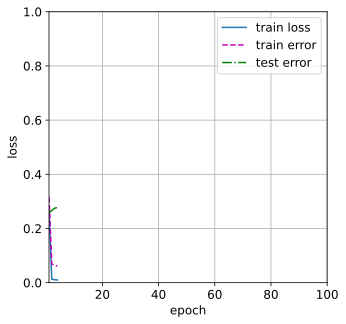

In [ ]:
if (test_env == 'guanabana'):
  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  net, predictions, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                 combined_dfs,
                                                                 country_years,
                                                                 best_params,
                                                                 is_validation=True,
                                                                 early_stopping=True,
                                                                 visualize=True)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["idn", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['idn']).drop(columns=['idn'])
  pd_cv_preds = pd_cv_preds[[id_col, 'FYEAR', 'YIELD', 'YIELD_PRED']]

  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  valid_nrmse = NormalizedRMSE(pd_cv_preds['YIELD'].values,
                               pd_cv_preds['YIELD_PRED'].values)
  valid_info += '\n' + crop + ', ' + ' NRMSE:' + str(valid_nrmse)
  print('\n', crop, 'Normalized RMSE:', valid_nrmse)
  print(pd_cv_preds.head(10))

  log_fh.write(valid_info)

### Evaluate on test data

NRMSE: 0.1442
Test NRMSE: 14.42

 grain maize Normalized RMSE: 14.42489736851222
   GRID_ID   FYEAR   YIELD  YIELD_PRED
0  4691686  2017.0  11.213    9.694842
1  4691686  2016.0  11.592   12.119663
2  4691686  2015.0  11.747   11.095248
3  4691686  2014.0  12.285   10.379540
4  4691686  2013.0   8.566    9.051650
5  4691686  2018.0  11.241   11.959373
6  4695285  2015.0  11.446   10.774748
7  4695285  2016.0  12.267   12.357033
8  4695285  2017.0  11.873    9.686503
9  4695285  2018.0  12.124   12.479528


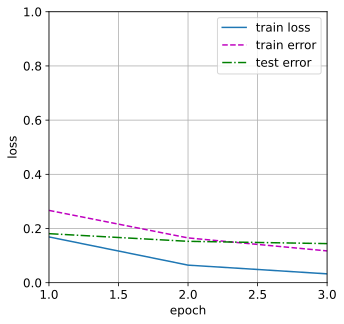

In [ ]:
if (test_env == 'guanabana'):
  id_df = combined_dfs['NUMERIC_IDS']
  net, predictions, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                combined_dfs,
                                                                country_years,
                                                                best_params,
                                                                is_validation=False,
                                                                early_stopping=False,
                                                                visualize=True)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["idn", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['idn']).drop(columns=['idn'])
  pd_test_preds = pd_test_preds[[id_col, 'FYEAR', 'YIELD', 'YIELD_PRED']]
  test_info = '\nTest Set NRMSEs'
  test_info += '\n-----------------'
  test_nrmse = NormalizedRMSE(pd_test_preds['YIELD'].values,
                              pd_test_preds['YIELD_PRED'].values)
  valid_info += '\n' + crop + ', ' + ' NRMSE:' + str(test_nrmse)
  print('\n', crop, 'Normalized RMSE:', test_nrmse)
  print(pd_test_preds.head(10))

  # Save predictions
  output_path = cyp_config['output_path']
  pred_file = getPredictionFilename(cyp_config['crop'],
                                    cyp_config['use_yield_trend'],
                                    cyp_config['early_season_end_dekad'],
                                    country=cyp_config['country_code'],
                                    spatial_level=cyp_config['spatial_level'],
                                    architecture=cyp_config['architecture'])

  pd_test_preds.to_csv(output_path + '/' + pred_file + '.csv', index=False)

  log_fh.write(test_info)

### Evaluate Multiple Runs

#### Datasets

In [ ]:
test_fraction = cyp_config['test_fraction']
use_yield_trend = cyp_config['use_yield_trend']
early_season_end = cyp_config['early_season_end_dekad']
print_debug = cyp_config['debug_level'] > 1
num_valid_years = 5

scaler_args = {}
train_dataset = CYPMLDataset(combined_dfs, country_years,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

valid_dataset = CYPMLDataset(combined_dfs, country_years,
                             early_season_end=early_season_end,
                             is_train=False, is_validation=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             print_debug=print_debug,
                             log_fh=log_fh)

scaler_args = {}
train_dataset2 = CYPMLDataset(combined_dfs, country_years,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=True,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=0,
                              scaler_args=scaler_args,
                              print_debug=print_debug,
                              log_fh=log_fh)

test_dataset = CYPMLDataset(combined_dfs, country_years,
                            early_season_end=early_season_end,
                            is_train=False, is_validation=False,
                            test_fraction=test_fraction,
                            num_folds=1, fold_iter=0,
                            num_valid_years=0,
                            scaler_args=scaler_args,
                            print_debug=print_debug,
                            log_fh=log_fh)

datasets = {
    'valid' : [train_dataset, valid_dataset],
    'test' : [train_dataset2, test_dataset]
}


----------------
Training data
----------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Dekadal data: 6316, 30, 8
Other feature data: 916, 1
Trend feature data: 6316, 5
Label data: 6316, 3

------------------
Validation data
------------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Validation years: 2007, 2008, 2009, 2010, 2011


Dekadal data: 4250, 30, 8
Other feature data: 916, 1
Trend feature data: 4250, 5
Label data: 4250, 3

----------------
Training data
----------------


Dekadal features: TAGP, TWSO, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

 Training years: 20

#### Training and Evaluation

In [ ]:
def trainAndTest(cyp_config, best_params,
                 train_dataset, test_dataset,
                 early_stopping=False,
                 visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  net.double()
  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

#### Evaluate Multiple Runs

In [ ]:
import pandas as pd
import statistics as stat

num_iters = 10
valid_set_nrmses = []
test_set_nrmses = []
for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)
  net, predictions, valid_nrmse = trainAndTest(cyp_config, best_params,
                                               datasets['valid'][0], datasets['valid'][1],
                                               early_stopping=True, visualize=False, country=country)
  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["idn", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['idn']).drop(columns=['idn'])
  pd_cv_preds = pd_cv_preds[[id_col, 'FYEAR', 'YIELD', 'YIELD_PRED']]

  valid_info += '\n\nValidation NRMSEs'
  valid_info += '\n---------------------'
  valid_nrmse = NormalizedRMSE(pd_cv_preds['YIELD'].values,
                               pd_cv_preds['YIELD_PRED'].values)
  valid_info += '\n' + crop + ', US NRMSE:' + str(valid_nrmse)
  valid_set_nrmses.append(valid_nrmse)

  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  id_df = combined_dfs['NUMERIC_IDS']
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, predictions, test_nrmse = trainAndTest(cyp_config, best_params,
                                              datasets['test'][0], datasets['test'][1],
                                              early_stopping=False, visualize=False, country=country)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["idn", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['idn']).drop(columns=['idn'])
  pd_test_preds = pd_test_preds[[id_col, 'FYEAR', 'YIELD', 'YIELD_PRED']]

  output_path = cyp_config['output_path']
  pred_file = getPredictionFilename(cyp_config['crop'],
                                    cyp_config['use_yield_trend'],
                                    cyp_config['early_season_end_dekad'],
                                    country=cyp_config['country_code'],
                                    spatial_level=cyp_config['spatial_level'],
                                    architecture=cyp_config['architecture'])

  pd_test_preds.to_csv(output_path + '/' + pred_file + '-' + str(i) + '.csv', index=False)

  test_info += '\n\nTest NRMSEs'
  test_info += '\n-----------------'
  test_nrmse = NormalizedRMSE(pd_test_preds['YIELD'].values,
                              pd_test_preds['YIELD_PRED'].values)
  test_info += '\n' + crop + ', US NRMSE:' + str(test_nrmse)
  test_set_nrmses.append(test_nrmse)

  print(test_info)
  log_fh.write(test_info)

valid_info = '\n\nAverage Validation Set NRMSEs'
valid_info += '\n----------------------------'
avg_valid_nrmse = round(stat.fmean(valid_set_nrmses), 3)
valid_info += '\n' + crop + ', US: ' + str(avg_valid_nrmse)

print(valid_info)
log_fh.write(valid_info)

test_info = '\n\nAverage Test Set NRMSEs'
test_info += '\n----------------------------'
avg_test_nrmse = round(stat.fmean(test_set_nrmses), 3)
test_info += '\n' + crop + ', US: ' + str(avg_test_nrmse)

log_fh.write(test_info)
print(test_info)


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1369

Validation NRMSE:13.691

Validation NRMSEs
---------------------
grain maize, US NRMSE:13.690882882413616


Test Set Evaluation
----------------------------
NRMSE: 0.1855

Test NRMSE: 18.55

Test NRMSEs
-----------------
grain maize, US NRMSE:18.546748075245688

Iteration 2
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1495

Validation NRMSE:14.946

Validation NRMSEs
---------------------
grain maize, US NRMSE:14.945664844476752


Test Set Evaluation
----------------------------
NRMSE: 0.1834

Test NRMSE: 18.34

Test NRMSEs
-----------------
grain maize, US NRMSE:18.33622626496249

Iteration 3
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1469

Validation NRMSE:14.688

Validation NRMSEs
---------------------
grain maize, US NRMSE:14.688414503643155


Test Set Evaluation
----------------------------
NRMSE

### Close file handle

In [ ]:
log_fh.close()